In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor (range [0, 1])
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST
])

# Load datasets
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
#custom transforms

class AddSaltPepperNoise(object):
    def __init__(self, prob=0.05):
        self.prob = prob  # Probability of noise
        
    def __call__(self, tensor):
        noisy_tensor = tensor.clone()
        mask = torch.rand(tensor.size()) < self.prob
        noisy_tensor[mask] = torch.randint(0, 2, mask.shape).float()[mask]
        return noisy_tensor
# Define transforms with noise

saltpepper_transform = transforms.Compose([
    transforms.ToTensor(),
    AddSaltPepperNoise(prob=0.1)  # 10% pixels corrupted
])


# Load noisy MNIST

saltpepper_mnist = datasets.MNIST(
    root='./data/saltpepper_noise', 
    train=False, 
    download=True, 
    transform=saltpepper_transform
)

In [4]:
# from torchvision.models import resnet18

# model = resnet18(num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
# model = model.to(device)

In [5]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 after 2 max-poolings
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    # for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc="Processing", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}")

# Train for 5 epochs
for epoch in range(1, 3):
    train(model, device, train_loader, optimizer, epoch)
    
torch.save(model.state_dict(), './weights/mnist_weights.pth')

Train Epoch: 1 [0/60000] Loss: 2.2954
Train Epoch: 1 [6400/60000] Loss: 0.1828
Train Epoch: 1 [12800/60000] Loss: 0.0702
Train Epoch: 1 [19200/60000] Loss: 0.0509
Train Epoch: 1 [25600/60000] Loss: 0.1191
Train Epoch: 1 [32000/60000] Loss: 0.0146
Train Epoch: 1 [38400/60000] Loss: 0.0140
Train Epoch: 1 [44800/60000] Loss: 0.0629
Train Epoch: 1 [51200/60000] Loss: 0.0708
Train Epoch: 1 [57600/60000] Loss: 0.0945
Train Epoch: 2 [0/60000] Loss: 0.0175
Train Epoch: 2 [6400/60000] Loss: 0.0256
Train Epoch: 2 [12800/60000] Loss: 0.0477
Train Epoch: 2 [19200/60000] Loss: 0.0107
Train Epoch: 2 [25600/60000] Loss: 0.1748
Train Epoch: 2 [32000/60000] Loss: 0.0095
Train Epoch: 2 [38400/60000] Loss: 0.0060
Train Epoch: 2 [44800/60000] Loss: 0.0563
Train Epoch: 2 [51200/60000] Loss: 0.1201
Train Epoch: 2 [57600/60000] Loss: 0.0026


In [130]:
model.load_state_dict(torch.load('./weights/mnist_weights.pth'))

<All keys matched successfully>

In [30]:
criterion = nn.CrossEntropyLoss()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_probs = []  # Store probabilities for analysis
    all_targets = []
    
    with torch.no_grad():
        for i , (data, target) in tqdm(enumerate(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            # Optional: Get probabilities
            probs = F.softmax(output, dim=1)
            all_probs.append(probs.cpu())
            all_targets.append(target.cpu())
            
            # Prediction (works with or without softmax)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    
    # Optional: Return probabilities for further analysis
    return torch.cat(all_probs), torch.cat(all_targets)

test_loader = DataLoader(saltpepper_mnist, batch_size=100, shuffle=False)
test(model, device, test_loader)

100it [00:04, 21.44it/s]


Test set: Average loss: 0.0080, Accuracy: 9307/10000 (93.07%)



(tensor([[0.0233, 0.0226, 0.0626,  ..., 0.6203, 0.0452, 0.0359],
         [0.0319, 0.1041, 0.7117,  ..., 0.0205, 0.0343, 0.0099],
         [0.0548, 0.2787, 0.1381,  ..., 0.1313, 0.0766, 0.0662],
         ...,
         [0.0129, 0.0515, 0.0452,  ..., 0.1439, 0.0653, 0.0767],
         [0.0208, 0.0128, 0.0155,  ..., 0.0203, 0.0968, 0.0202],
         [0.1062, 0.0406, 0.1375,  ..., 0.0287, 0.0846, 0.0326]]),
 tensor([7, 2, 1,  ..., 4, 5, 6]))

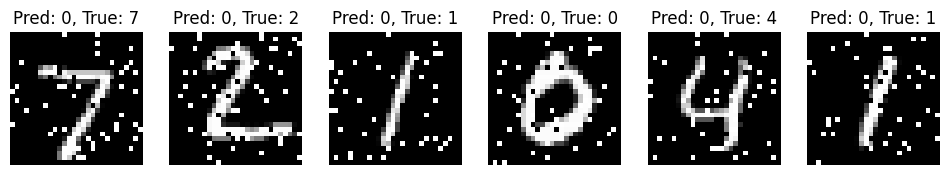

In [28]:
test_loader = DataLoader(saltpepper_mnist, batch_size=1, shuffle=False)

def plot_predictions(model, test_loader, device, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    model.eval()
    with torch.no_grad():
        for i , (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
        
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)

            axes[i].imshow(data.cpu().squeeze(), cmap='gray')
            axes[i].set_title(f"Pred: {preds.item()}, True: {target.item()}")
            axes[i].axis('off')
    plt.show()

plot_predictions(model, test_loader, device)

[0.05203527 0.02317794 0.08057339 0.22909786 0.01180126 0.06893947
 0.01103323 0.40383315 0.07724379 0.04226471]
[0.0250478  0.10711875 0.77618045 0.01685569 0.01294344 0.00349718
 0.01059321 0.0270141  0.0137996  0.0069498 ]
[0.04980842 0.23622471 0.05610247 0.06924066 0.11954264 0.08303867
 0.05776808 0.13258183 0.11616982 0.07952261]
[0.47473052 0.01962028 0.0694178  0.02891441 0.05973428 0.04734676
 0.12533781 0.02846993 0.07093746 0.07549069]
[0.02273981 0.02816922 0.05162757 0.03163211 0.5806734  0.06027325
 0.0199516  0.02792424 0.05474127 0.12226763]


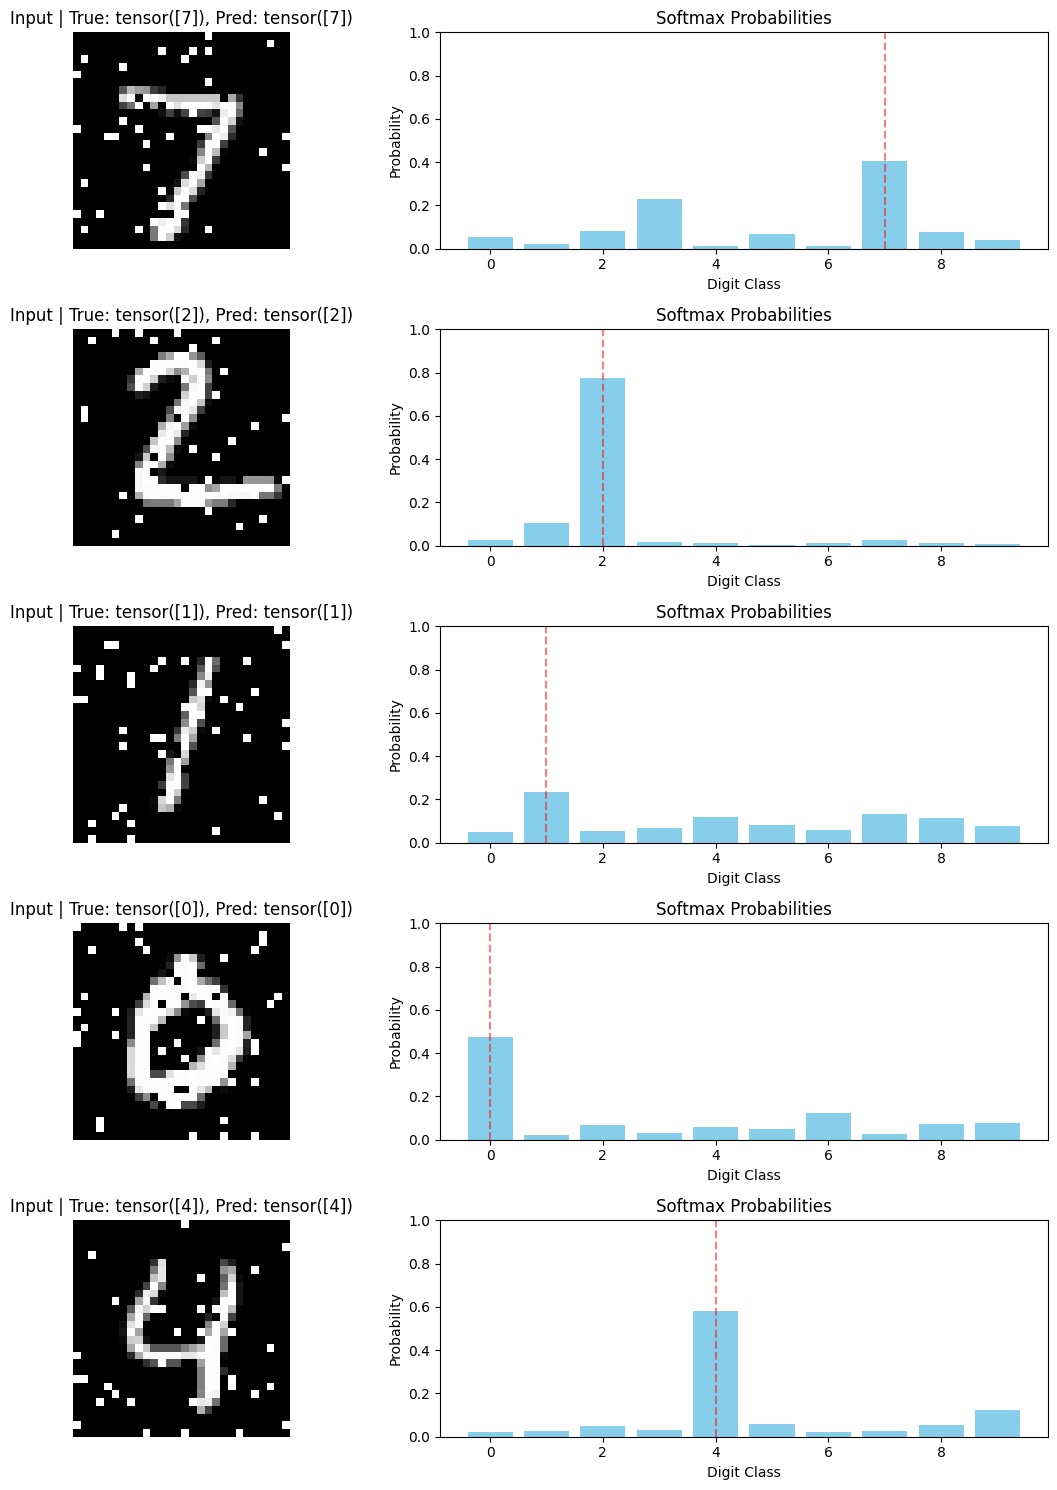

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import softmax

def visualize_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = softmax(outputs, dim=1).cpu().numpy().squeeze()
            pred = outputs.argmax(dim=1)
            print(probs)
            
            #Plot input image and prediction
            axes[i, 0].imshow(images[0].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title(f"Input | True: {labels}, Pred: {pred}")
            axes[i, 0].axis('off')
            
            # Plot softmax distribution
            axes[i, 1].bar(range(10), probs, color='skyblue')
            axes[i, 1].set_ylim(0, 1)
            axes[i, 1].set_title("Softmax Probabilities")
            axes[i, 1].set_xlabel("Digit Class")
            axes[i, 1].set_ylabel("Probability")
            axes[i, 1].axvline(x=pred, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(model, test_loader, device, num_samples=5)

In [ ]:
from kfac.kfac import KFAC
from kfac.grad import KFGrad


In [59]:
def train_fisher(kfac:KFAC,
                loader: DataLoader
                ) -> KFAC: 
    '''Empirical fisher computation by KFAC
        Update kfac state dict 
    '''

    for batch_idx, (data, target) in tqdm(enumerate(loader), desc="Processing", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
        data, target = data.to(device), target.to(device)
        # optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        kfac.update(log = False)
        # if batch_idx % 1000 == 1:
            
            # print(f"Fisher estimation :[{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}")
            # with open(filepath, 'wb') as f:
            #     pickle.dump(kfac.state, f)

    return kfac.state

In [93]:
import pickle, os 
filename = "mnist_fisher.pkl"
filepath = os.path.join("./weights/", filename)

fisher_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()  # Use running mean/var instead of batch stats
    else:
        module.train()

mykfac = KFAC(model, device = device)

state_dict = train_fisher(mykfac, fisher_loader)



Processing: |          | 3147/? [01:49<00:00]


KeyboardInterrupt: 

In [ ]:


mykfac.load(state_dict)


Calculating layerwise eigenspectrum of the KFAC factors
Computing eigenvalues/vectors for layer conv1 index :[0/4]
Computing eigenvalues/vectors for layer conv2 index :[1/4]
Computing eigenvalues/vectors for layer fc1 index :[2/4]
Computing eigenvalues/vectors for layer fc2 index :[3/4]
Inverting fisher for layer conv1
Inverting fisher for layer conv2
Inverting fisher for layer fc1
PyTorch Cholesky is singular. Using Numpy.
Inverting fisher for layer fc2
PyTorch Cholesky is singular. Using Numpy.


In [ ]:

eps = 1e-12
mykfac.kf_eigens()
add = [torch.min(torch.min(q), torch.min(h)) for (q,h) in list(kfac.eigvals.values())]
print(add)
add = [torch.abs(x) if x<0 else eps if x==0. else 0. for x in add]
print(add)
multiply = [1.]*len(mykfac.eigvals)
mykfac.invert(add, multiply)

Calculating layerwise eigenspectrum of the KFAC factors
Computing eigenvalues/vectors for layer conv1 index :[0/4]
Computing eigenvalues/vectors for layer conv2 index :[1/4]
Computing eigenvalues/vectors for layer fc1 index :[2/4]
Computing eigenvalues/vectors for layer fc2 index :[3/4]
[tensor(2.5164e-05), tensor(3.0499e-06), tensor(-0.0049), tensor(-0.0020)]
[0.0, 0.0, tensor(0.0049), tensor(0.0020)]
Inverting fisher for layer conv1
Inverting fisher for layer conv2
Inverting fisher for layer fc1
PyTorch Cholesky is singular. Using Numpy.
Inverting fisher for layer fc2
PyTorch Cholesky is singular. Using Numpy.


In [107]:
# kfac.model.load_state_dict(model.state_dict())
# kfac.model.state_dict()
kfac.inv_state['fc1']

(tensor([[14.2700,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, 14.2700,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, 14.2700,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ..., 14.2700,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 14.2700,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.1295]]),
 tensor([[14.2700,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, 14.2700,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, 14.1129,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.2414,  ..., 13.8804,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 14.2700,  0.0000],
         [ 0.0000,  0.0000,  0.0898,  ..., -0.1526,  0.0000, 14.2370]]))

In [15]:
# from curvature.curvatures import KFAC
# curvature_checkpoint =  "./weights/mnist_fisher.pkl"
# import pickle

# # kfac = KFAC(model = model, device = device)
# with open(curvature_checkpoint, 'rb') as f:
#     state_dict = pickle.load(f)

# kfac.load(state_dict)

In [133]:
test_loader = DataLoader(saltpepper_mnist, batch_size=1, shuffle=True)

image, label = next(iter(test_loader))
output = kfac.model(image)
output

/home/romie/anaconda3/envs/mcglm/lib/python3.11/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


tensor([[-1.2076, -2.2398, -1.6699,  0.5248, -1.3314,  3.4943, -0.3211, -1.7312,
          0.2763,  0.0191]], grad_fn=<AddmmBackward0>)

predicion = tensor([0])


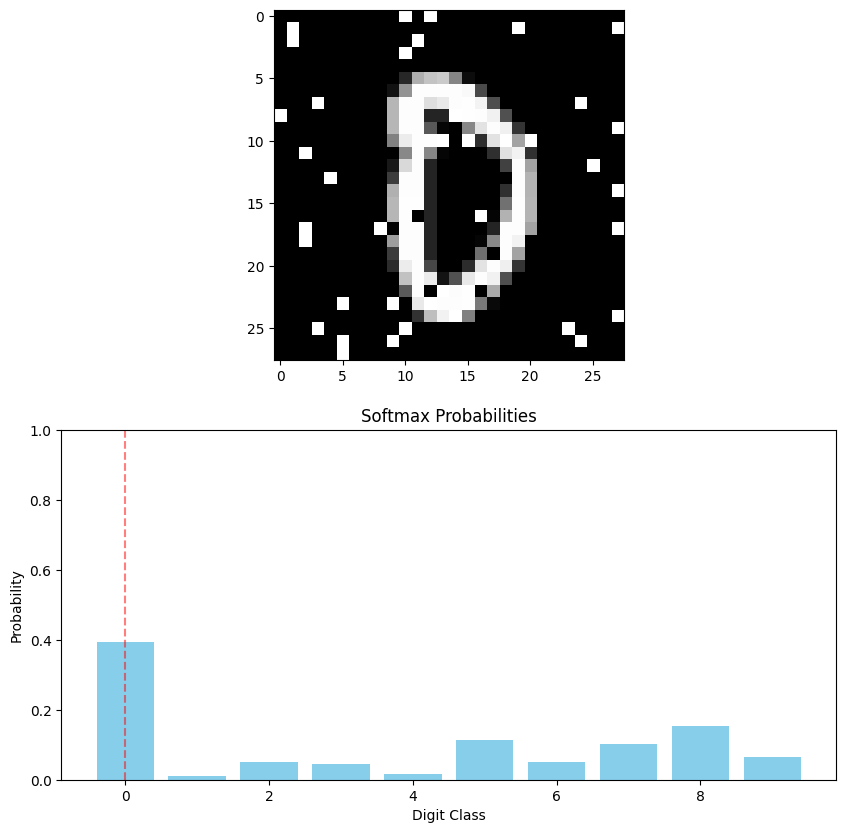

In [103]:
probs = softmax(output, dim=1).detach().numpy().squeeze()
pred = output.argmax(dim=1)
print(f'predicion = {pred}')
fig, axes = plt.subplots(2, figsize=(10, 10))
axes[0].imshow(image[0].numpy().squeeze(), cmap = 'gray')
axes[1].bar(range(10), probs, color='skyblue')
axes[1].set_ylim(0, 1)
axes[1].set_title("Softmax Probabilities")
axes[1].set_xlabel("Digit Class")
axes[1].set_ylabel("Probability")
axes[1].axvline(x=pred, color='red', linestyle='--', alpha=0.5)

100%|██████████| 16/16 [00:00<00:00, 30.86it/s]


tensor([[[ 8.8291e+02, -1.2577e+02, -4.9007e+02, -2.1542e+01, -9.0930e+01,
           1.7235e+02, -5.5511e+00, -3.4245e+01,  4.7732e+02, -5.0831e+01],
         [-1.2577e+02,  8.4948e+02,  2.9857e+02,  3.2911e+02, -1.6393e+02,
          -2.5086e+02,  2.8990e+01,  2.3965e+02, -5.1346e+02, -4.0655e+02],
         [-4.9007e+02,  2.9857e+02,  8.4049e+02,  5.2168e+02, -1.5193e+02,
          -1.2742e+02, -2.3553e+02,  6.5833e+02, -4.1253e+02,  7.5577e+01],
         [-2.1542e+01,  3.2911e+02,  5.2168e+02,  2.3177e+03, -8.1151e+02,
           1.2651e+02, -8.2700e+02,  1.5078e+03, -1.6344e+02,  4.0353e+02],
         [-9.0930e+01, -1.6393e+02, -1.5193e+02, -8.1151e+02,  1.5907e+03,
           1.4339e+02,  3.3399e+02, -2.1601e+00,  1.5451e+02,  5.6387e+02],
         [ 1.7235e+02, -2.5086e+02, -1.2742e+02,  1.2651e+02,  1.4339e+02,
           8.5852e+02,  8.0824e+01,  5.4050e+02,  5.5061e+02, -1.3697e+02],
         [-5.5511e+00,  2.8990e+01, -2.3553e+02, -8.2700e+02,  3.3399e+02,
           8.0824e+

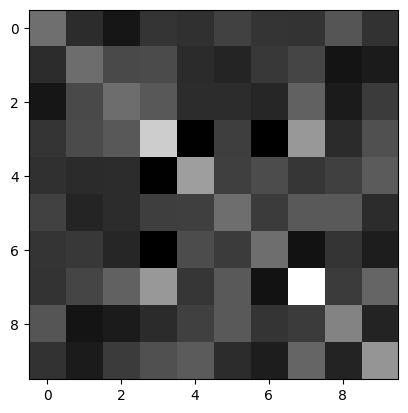

In [128]:

eps = 1e-6
mc_preds = []
iters = 16
with torch.no_grad():
    for i in tqdm(range(iters)):
        # print(f'sampling new weights from posterior: iteration {i}')
        mykfac.sample_and_replace(eps = eps)
        output_logits_mc = mykfac.model(image)
        # print(output_logits_mc)
        mc_preds.append(output_logits_mc)

mc_output_stacked = torch.stack(mc_preds) 

A = (mc_output_stacked - output)/eps 

B = torch.matmul(A.permute(1,2,0), A.permute(1,0,2))
print(B)
print(torch.diagonal(B))
plt.imshow(B.detach().numpy().squeeze(), cmap='grey')
# plt.plot(torch.diagonal(B).detach().numpy().squeeze())
# plt.xlabel("class label")
# plt.ylabel('uncertainty')

Text(0, 0.5, 'uncertainty')

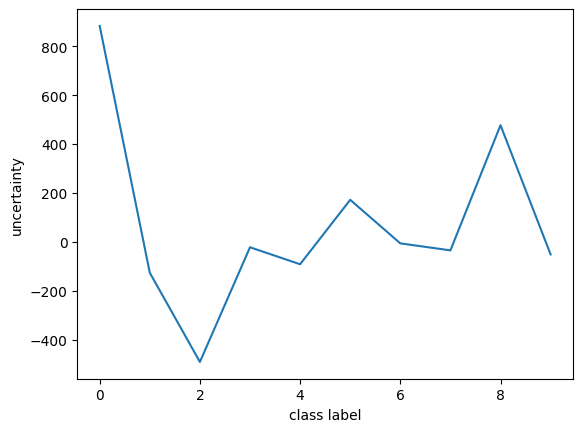

In [129]:
plt.plot(torch.diagonal(B).detach().numpy().squeeze())
plt.xlabel("class label")
plt.ylabel('uncertainty')

In [ ]:
image, label = next(iter(test_loader))
output = mykfac.model(image)
norm = torch.norm(output)
print(norm)
torch.autograd.set_detect_anomaly(True)
norm.backward(retain_graph=True)


tensor(4.3595, grad_fn=<LinalgVectorNormBackward0>)


In [ ]:

for i in range(10):
    out = output[0][i]
    mykfac.model.zero_grad()
    out.backward()
    